Josh Rubin – October, 2019

## Introduction
Even a simple NLP problem has a lot of steps and they need to be executed quickly and thoughtfully.  The purpose of this sheet is to provide a scaffold workflow with copy-and-paste syntax for the tools involved in order to maximize your time interacting intelligently with your interviewer. 

### Example workflow
1. **Describe your approach** – make a short outline so that your interviewer knows what you're thinking and verify that it makes sense to them.
1. **Load data** – this will typically be in a .csv or .json file.  I like to use Pandas for this.  Sometimes a dataset available in scikit-learn will be used.
1. **Take a look** – Make a few histograms to get a look what classes are present and whether the data is balanced.
1. **Vectorize** – Use a model to embed raw text into a vector space where you can use data science tools.
    * TFIDF
    * word2vec (to have access to pretrained embeddings, install `pip install spacy` (40MB) and `python -m spacy download en_core_web_md` (91MB))
    * Universal Sentence Encoder, [BERT Embeddings](https://pypi.org/project/bert-embedding/) (`pip install bert-embedding` (might be big)) 
1. **Reduce dimensionality** - This is necessary for EDA/visualization and usually necessary for supervised modeling.  For data challenge problems, if you can't discriminate with your eyes in 2D, think about narrowing the scope of the problem (more specific classes?) before trying to model in higher dimensions.  If you do want to try to find subsequent gains, how much data do you have once it's balanced?  This tells you about how big a feature-vector you can support (i.e. the dimensionality).
    * PCA
    * tSNE (good for visualizing complex lower-dimensional structures in high dimensional space, but not useful for subsequent embedding - i.e. no reusable transform)
    * UMAP (Neighbor embeddings like tSNE, but transform reusable and invertible.)   Find here: `pip umap-learn`
1. **Take another look** – How does your embedded text look in scatter plots.  Is there any interesting structure?  Are there anomalies or outliers?  You can investigate these further.
1. **Analyze**
    * Supervised?  Model it.
        - Start simple with linear or logistic regression (for continuous and categorical targets respectively.)
        - Trees/forests
        - Neural networks
    * Unsupervised?  Find clusters.
        - k-nearest neighbors
1. **Evaluate**
    * Confusion Matrix
    * Precision, recall, F1
    * Plot clusters
    
Finally, remember most of these commands have good doc strings with defaults and common configuration parameters.  e.g. `MLPClassifier?`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Example Data

[200K Jeopardy Questions]('https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/')

To download this, run the following:

In [2]:
file = 'JEOPARDY_QUESTIONS1.json.gz'

In [3]:
import urllib.request
url  = 'http://skeeto.s3.amazonaws.com/share/JEOPARDY_QUESTIONS1.json.gz'
urllib.request.urlretrieve(url, file);

*alternatively:*

(In case the above data becomes unavailable or it's more data than you want to download, I've downsampled 5000 questions and saved with this nodebook in GitHub (1MB).)

``` python
df = pd.read_json('JEOPARDY_QUESTIONS.json')
df.sample(5000).to_json('5000_JEOPARDY_QUESTIONS.json')
```

In [ ]:
## Uncomment below if you want to use the small version
# file = '5000_JEOPARDY_QUESTIONS.json'

## Load and Manipulate Data

Import data show head:

In [4]:
## CSV
# pandas.read_csv(file_path, nrows=)

## JSON
df = pd.read_json(file)  

df.head()

,air_date,answer,category,question,round,show_number,value
0,2004-12-31,Copernicus,HISTORY,"'For the last 8 years of his life, Galileo was...",Jeopardy!,4680,$200
1,2004-12-31,Jim Thorpe,ESPN's TOP 10 ALL-TIME ATHLETES,'No. 2: 1912 Olympian; football star at Carlis...,Jeopardy!,4680,$200
2,2004-12-31,Arizona,EVERYBODY TALKS ABOUT IT...,'The city of Yuma in this state has a record a...,Jeopardy!,4680,$200
3,2004-12-31,McDonald\'s,THE COMPANY LINE,"'In 1963, live on ""The Art Linkletter Show"", t...",Jeopardy!,4680,$200
4,2004-12-31,John Adams,EPITAPHS & TRIBUTES,"'Signer of the Dec. of Indep., framer of the C...",Jeopardy!,4680,$200


Sampling and selection:

In [5]:
# Select n samples at random
df.sample(2)

# Retrieve a specific range of indices
# df.iloc[1:25]

,air_date,answer,category,question,round,show_number,value
16792,1998-12-11,Super Chicken,TV THEME SONGS,"'""When it looks like you will take a lickin'.....",Jeopardy!,3285,$500
22860,1997-06-25,Free admission,FOREIGN WORDS & PHRASES,"'When sightsseing in France, you should know t...",Jeopardy!,2968,$200


Use apply to overwrite or create dataframe rows for data cleaning or modification via lambda functions:

In [6]:
# Create a column with integer question values rather than strings
# (remove dollar signs, commas, and if None, return 0):

df['value_int'] = df['value'].apply(lambda x: int(x[1:].replace(',','')) if x else 0)

# Shift questions to lower case and drop leading and trailing quotes:

df['question_processed'] = df['question'].apply(lambda x: x[1:-1].lower())

df.head(2)[['question','value','question_processed','value_int']]

,question,value,question_processed,value_int
0,"'For the last 8 years of his life, Galileo was...",$200,"for the last 8 years of his life, galileo was ...",200
1,'No. 2: 1912 Olympian; football star at Carlis...,$200,no. 2: 1912 olympian; football star at carlisl...,200


In [7]:
# Describe data
df.describe()

,show_number,value_int
count,216930.000000,216930.000000
mean,4264.238519,739.988476
std,1386.296335,639.822693
min,1.000000,0.000000
25%,3349.000000,400.000000
50%,4490.000000,600.000000
75%,5393.000000,1000.000000
max,6300.000000,18000.000000


In [8]:
# Describe set grouped by categories
df.groupby('round').describe()

show_number                                            \
                       count         mean          std     min     25%   
round                                                                    
Double Jeopardy!    105912.0  4264.161644  1387.287091     1.0  3348.0   
Final Jeopardy!       3631.0  4253.917929  1395.089657     1.0  3340.5   
Jeopardy!           107384.0  4264.666757  1385.041201     1.0  3350.0   
Tiebreaker               3.0  4141.000000  1195.525408  2941.0  3545.5   

                                          value_int                           \
                     50%      75%     max     count         mean         std   
round                                                                          
Double Jeopardy!  4492.0  5393.25  6298.0  105912.0  1017.291742  755.440606   
Final Jeopardy!   4471.0  5388.50  6298.0    3631.0     0.000000    0.000000   
Jeopardy!         4488.5  5393.00  6300.0  107384.0   491.528505  328.659267   
Tiebreaker        4150.0  4741.00  5332.0       3.0     0.000000    0.000000   

                                                      
                  min    25%    50%     75%      max  
round                                                 
Double Jeopardy!  5.0  400.0  800.0  1500.0  18000.0  
Final Jeopardy!   0.0    0.0    0.0     0.0      0.0  
Jeopardy!         5.0  200.0  400.0   600.0   6600.0  
Tiebreaker        0.0    0.0    0.0     0.0      0.0

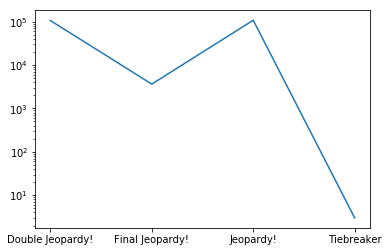

In [9]:
def pandas_counts(df, col):
    return (list(df.groupby(col).count()[df.columns[0]].index),
            list(df.groupby(col).count()[df.columns[0]].to_list()))

plt.plot(*pandas_counts(df, 'round'))
plt.yscale('log')

## NLP Feature Extraction

[TFIDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
TFIDF = np.asarray(vectorizer.fit_transform(df['question_processed']).todense())
print(vectorizer.get_feature_names()[-10:])
print(TFIDF.shape)

['writing', 'written', 'wrote', 'wwii', 'www', 'year', 'years', 'yellow', 'york', 'young']
(216930, 1000)


[word2vec using spaCy](https://spacy.io/usage/vectors-similarity) – pretrained word and document embedding vectors.

Pretrained word2vec and averaged word2vec (over a document).

In [11]:
import spacy
nlp = spacy.load('en_core_web_md')

In [12]:
out = nlp(df.iloc[2]['question_processed'])
print(out)
print(out.vector[:5])
print(f'Length of embedding vector: {len(out.vector)}')

the city of yuma in this state has a record average of 4,055 hours of sunshine each year
[ 0.06046849  0.21475472  0.0735155  -0.08993094  0.09578883]
Length of embedding vector: 300


In [ ]:
# This takes some time...
df['embedding'] = df['question_processed'].apply(lambda x: nlp(x).vector)

## Dimensionality Reduction

[PCA (Principal Component Analysis)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

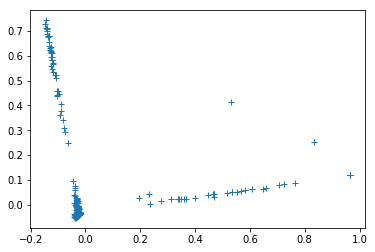

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_TFIDF = pca.fit_transform(TFIDF)
#pca.inverse_transform(pca.transform(X[8:]))

small = pca_TFIDF[:1000]
plt.plot(small[:,0],small[:,1],'+');

[tSNE (t-distributed Stochastic Neighbor Embedding)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

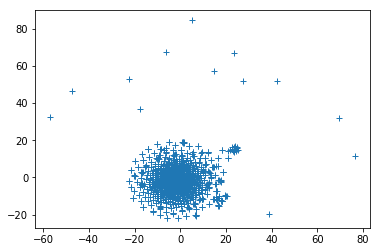

In [15]:
from sklearn.manifold import TSNE
tsne_TFIDF = TSNE(n_components=2).fit_transform(TFIDF[:1000])

plt.plot(tsne_TFIDF[:,0],tsne_TFIDF[:,1],'+');

[UMAP (Uniform Manifold Approximation and Projection)](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) 

Install with `pip install umap-learn`

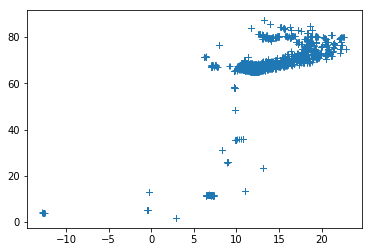

In [30]:
import umap
reducer = umap.UMAP(n_neighbors = 15) # n_components=2, n_neighbors=15,
umap_TFIDF = reducer.fit_transform(TFIDF[:3000]) 
#reducer.transform(X) 

plt.plot(umap_TFIDF[:,0],umap_TFIDF[:,1],'+');

## Modeling
[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :]) 
clf.score(X, y)

[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [ ]:
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_ 
reg.predict(np.array([[3, 5]]))

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=5) # Better settings to prevent overfitting in NLP
clf.fit(X_train, y_train)  

y_predict = clf.predict(X_test)

[MLPRegressor (Multilayer Perceptron Regressor)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

[MLPClassifier (Multilayer Perceptron Classifier)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
MLPClassifier?

### Data Utilities
[Train Test Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
from sklearn.model_selection import train_test_split
## Works on numpy arrays
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Also works directly on pandas dataframes and retruns dataframes
X_train, X_test, y_train, y_test = train_test_split(df['show_number'], df['value'], test_size=0.33, random_state=42)

[Standardize (Normalize) feature vector](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [20]:
>>> from sklearn.preprocessing import StandardScaler
>>> data = [[0, 0], [0, 0], [1, 1], [1, 1]]
>>> scaler = StandardScaler()
>>> print(scaler.fit(data))
>>> print(scaler.mean_)
>>> print(scaler.transform(data))
>>> print(scaler.transform([[2, 2]]))


StandardScaler(copy=True, with_mean=True, with_std=True)
[0.5 0.5]
[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[[3. 3.]]


[Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [22]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

[Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))
#               precision    recall  f1-score   support

#      class 0       0.50      1.00      0.67         1
#      class 1       0.00      0.00      0.00         1
#      class 2       1.00      0.67      0.80         3

#     accuracy                           0.60         5
#    macro avg       0.50      0.56      0.49         5
# weighted avg       0.70      0.60      0.61         5

y_pred = [1, 1, 0]
y_true = [1, 1, 1]
print(classification_report(y_true, y_pred, labels=[1, 2, 3]))
#               precision    recall  f1-score   support

#            1       1.00      0.67      0.80         3
#            2       0.00      0.00      0.00         0
#            3       0.00      0.00      0.00         0

#    micro avg       1.00      0.67      0.80         3
#    macro avg       0.33      0.22      0.27         3
# weighted avg       1.00      0.67      0.80         3

### Plotting

In [ ]:
plt.plot(x[:,0],x[:,1],'+')
plt.xlim(-0.2,0.1)
plt.ylim(-0.06,0)